# 1 - Data Preperation


### Mount Google Drive and Unzip Dataset


In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q "/content/drive/MyDrive/Skin-Cancer-Detection/data/nev_classification/nev_classification.zip" -d "/content/nev_classification"

### Import Required Libraries


In [ ]:
import os
import random
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
from keras.utils import register_keras_serializable
from PIL import Image
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import DenseNet121, Xception
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        ReduceLROnPlateau)
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tqdm import tqdm

### Set Seed for Reproducibility


In [4]:
SEED = 55
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

### Load and Explore the Balanced Dataset


In [5]:
df = pd.read_csv('/content/nev_classification/nev_classification.csv')
df

,image_name,diagnosis,benign_malignant,target,path
0,ISIC_0071599,bcc,malignant,0,data/ISIC_2019/train/ISIC_0071599.jpg
1,ISIC_0063758,bkl,malignant,0,data/ISIC_2019/train/ISIC_0063758.jpg
2,ISIC_0073245,nv,benign,1,data/ISIC_2019/train/ISIC_0073245.jpg
3,ISIC_0010254,nv,benign,1,data/ISIC_2019/train/ISIC_0010254.jpg
4,ISIC_0068632,bcc,malignant,0,data/ISIC_2019/train/ISIC_0068632.jpg
...,...,...,...,...,...
15863,ISIC_0069732,bcc,malignant,0,data/ISIC_2019/train/ISIC_0069732.jpg
15864,ISIC_0067854,nv,benign,1,data/ISIC_2019/train/ISIC_0067854.jpg
15865,ISIC_0061181,scc,malignant,0,data/ISIC_2019/train/ISIC_0061181.jpg
15866,ISIC_0024737,nv,benign,1,data/ISIC_2019/train/ISIC_0024737.jpg


#### Distribution


In [6]:
df['benign_malignant'].value_counts()

,count
benign_malignant,
malignant,7934
benign,7934


In [7]:
df['target'].value_counts()

,count
target,
0,7934
1,7934


### Split Data into Train, Validation and Test Sets


In [8]:
X = df[['image_name', 'path']]
y = df['benign_malignant']

In [9]:
X

,image_name,path
0,ISIC_0071599,data/ISIC_2019/train/ISIC_0071599.jpg
1,ISIC_0063758,data/ISIC_2019/train/ISIC_0063758.jpg
2,ISIC_0073245,data/ISIC_2019/train/ISIC_0073245.jpg
3,ISIC_0010254,data/ISIC_2019/train/ISIC_0010254.jpg
4,ISIC_0068632,data/ISIC_2019/train/ISIC_0068632.jpg
...,...,...
15863,ISIC_0069732,data/ISIC_2019/train/ISIC_0069732.jpg
15864,ISIC_0067854,data/ISIC_2019/train/ISIC_0067854.jpg
15865,ISIC_0061181,data/ISIC_2019/train/ISIC_0061181.jpg
15866,ISIC_0024737,data/ISIC_2019/train/ISIC_0024737.jpg


In [10]:
y

,benign_malignant
0,malignant
1,malignant
2,benign
3,benign
4,malignant
...,...
15863,malignant
15864,benign
15865,malignant
15866,benign


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=SEED)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=SEED)

#### Display Class Distribution in Train, Validation, and Test Sets


In [12]:
df_train = pd.concat([X_train, y_train], axis=1)
print("Train:", df_train['benign_malignant'].value_counts().to_dict())

Train: {'malignant': 5712, 'benign': 5712}


In [13]:
df_val = pd.concat([X_val, y_val], axis=1)
print("Validation:", df_val['benign_malignant'].value_counts().to_dict())

Validation: {'benign': 1429, 'malignant': 1428}


In [14]:
df_test = pd.concat([X_test, y_test], axis=1)
print("Test:", df_test['benign_malignant'].value_counts().to_dict())

Test: {'malignant': 794, 'benign': 793}


### Update Image Paths for Google Colab Environment


In [15]:
NEW_ROOT = "/content/nev_classification/nev_images"

df_train['path'] = df_train['path'].apply(
    lambda x: os.path.join(NEW_ROOT, os.path.basename(x)))
df_val['path'] = df_val['path'].apply(
    lambda x: os.path.join(NEW_ROOT, os.path.basename(x)))
df_test['path'] = df_test['path'].apply(
    lambda x: os.path.join(NEW_ROOT, os.path.basename(x)))

In [16]:
df_train

,image_name,path,benign_malignant
12676,ISIC_0058487,/content/nev_classification/nev_images/ISIC_00...,malignant
12128,ISIC_0012375_downsampled,/content/nev_classification/nev_images/ISIC_00...,malignant
3277,ISIC_0054436,/content/nev_classification/nev_images/ISIC_00...,malignant
13391,ISIC_0032199,/content/nev_classification/nev_images/ISIC_00...,malignant
2027,ISIC_0032312,/content/nev_classification/nev_images/ISIC_00...,benign
...,...,...,...
11141,ISIC_0053831,/content/nev_classification/nev_images/ISIC_00...,benign
10994,ISIC_0070413,/content/nev_classification/nev_images/ISIC_00...,benign
11976,ISIC_0064578,/content/nev_classification/nev_images/ISIC_00...,malignant
3217,ISIC_0059379,/content/nev_classification/nev_images/ISIC_00...,benign


In [17]:
df_val

,image_name,path,benign_malignant
13669,ISIC_0061817,/content/nev_classification/nev_images/ISIC_00...,malignant
6962,ISIC_0053913,/content/nev_classification/nev_images/ISIC_00...,malignant
1928,ISIC_0069796,/content/nev_classification/nev_images/ISIC_00...,malignant
10255,ISIC_0062672,/content/nev_classification/nev_images/ISIC_00...,malignant
13604,ISIC_0063557,/content/nev_classification/nev_images/ISIC_00...,benign
...,...,...,...
3725,ISIC_0071294,/content/nev_classification/nev_images/ISIC_00...,malignant
6085,ISIC_0062333,/content/nev_classification/nev_images/ISIC_00...,benign
14266,ISIC_0024669,/content/nev_classification/nev_images/ISIC_00...,malignant
5827,ISIC_0025678,/content/nev_classification/nev_images/ISIC_00...,benign


In [18]:
df_test

,image_name,path,benign_malignant
2275,ISIC_0059050,/content/nev_classification/nev_images/ISIC_00...,malignant
11648,ISIC_0014958_downsampled,/content/nev_classification/nev_images/ISIC_00...,benign
6065,ISIC_0030810,/content/nev_classification/nev_images/ISIC_00...,benign
4176,ISIC_0028132,/content/nev_classification/nev_images/ISIC_00...,malignant
746,ISIC_0058459,/content/nev_classification/nev_images/ISIC_00...,malignant
...,...,...,...
12768,ISIC_0070355,/content/nev_classification/nev_images/ISIC_00...,malignant
9520,ISIC_0068482,/content/nev_classification/nev_images/ISIC_00...,malignant
5706,ISIC_0059186,/content/nev_classification/nev_images/ISIC_00...,malignant
4379,ISIC_0028727,/content/nev_classification/nev_images/ISIC_00...,benign


## Define Helper Function


### Visualize Training Metrics


In [19]:
def visualize_modeling_results(results):
    history = results.history
    plt.figure(figsize=(8, 5))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

### Visualize Confusion Matrix


In [20]:
def plot_confusion_matrices_only(model, data_generator, class_labels=['Benign', 'Malignant'], title_suffix=''):
    y_pred_probs = model.predict(data_generator)
    y_pred = (y_pred_probs > 0.5).astype("int32").flatten()
    y_true = data_generator.classes

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix {title_suffix}")
    plt.show()

    cm_norm = confusion_matrix(y_true, y_pred, normalize='true')
    disp_norm = ConfusionMatrixDisplay(
        confusion_matrix=cm_norm, display_labels=class_labels)
    disp_norm.plot(cmap='Greens')
    plt.title(f"Normalized Confusion Matrix {title_suffix}")
    plt.show()

### Evaluate Model to Dataframe


In [21]:
def evaluate_model_to_dataframe(model, train_gen, val_gen, metric_names=None):
    train_results = model.evaluate(train_gen, verbose=0)
    val_results = model.evaluate(val_gen, verbose=0)

    if metric_names is None:
        metric_names = model.metrics_names
    metric_names = [name.capitalize() if name !=
                    'loss' else 'Loss' for name in metric_names]

    results_df = pd.DataFrame(columns=metric_names, index=[
                              'Train', 'Validation'])
    results_df.loc['Train'] = train_results[:len(metric_names)]
    results_df.loc['Validation'] = val_results[:len(metric_names)]

    return results_df

### Save Model and Results


In [22]:
def save_model_and_results(model, model_name, model_dir, local_path, results_df=None):
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(local_path, exist_ok=True)

    model.save(os.path.join(model_dir, f"{model_name}.keras"))
    model.save(os.path.join(local_path, f"{model_name}.keras"))

    if results_df is not None:
        results_path = os.path.join(model_dir, f"{model_name}_results.csv")
        results_df.to_csv(results_path, index=False)

    print(f"Saved model to: {model_dir} and {local_path}")
    if results_df is not None:
        print(f"Saved results CSV to: {results_path}")

### Evaluate on Test Dataset


In [23]:
def evaluate_on_test_set(model, data_generator, class_labels=['Benign', 'Malignant'], title='Confusion Matrix - Test Set'):
    y_pred_probs = model.predict(data_generator, verbose=1)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()
    y_true = data_generator.classes

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# 2 - Model Training


## CNN


### Generate Data


In [ ]:
import gc

import tensorflow as tf
import torch

In [ ]:
IMG_SIZE = 224
EPOCHS = 100
BATCH_SIZE = 32

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    shear_range=0.20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='path',
    y_col='benign_malignant',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    df_val,
    x_col='path',
    y_col='benign_malignant',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False,
    class_mode='binary'
)

test_generator = val_datagen.flow_from_dataframe(
    df_test,
    x_col='path',
    y_col='benign_malignant',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False,
    class_mode='binary'
)

Found 11424 validated image filenames belonging to 2 classes.
Found 2857 validated image filenames belonging to 2 classes.
Found 1587 validated image filenames belonging to 2 classes.


### Custom-CNN


In [ ]:
model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    layers.Conv2D(32, (3, 3), padding='same',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), padding='same',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), padding='same',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), padding='same',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005)),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
loss_fn = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
    loss=loss_fn,
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10,
                  restore_best_weights=True, verbose=1),
    ModelCheckpoint('cnn_model.keras', monitor='val_loss',
                    save_best_only=True, verbose=1)
]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [ ]:
model_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - AUC: 0.7880 - Precision: 0.6954 - Recall: 0.8236 - accuracy: 0.7255 - loss: 0.9979
Epoch 1: val_loss improved from inf to 1.02275, saving model to cnn_model.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 244s 624ms/step - AUC: 0.7881 - Precision: 0.6955 - Recall: 0.8236 - accuracy: 0.7256 - loss: 0.9978 - val_AUC: 0.8374 - val_Precision: 0.5911 - val_Recall: 0.9720 - val_accuracy: 0.6500 - val_loss: 1.0227 - learning_rate: 0.0010
Epoch 2/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - AUC: 0.8742 - Precision: 0.7860 - Recall: 0.8107 - accuracy: 0.7953 - loss: 0.8967
Epoch 2: val_loss improved from 1.02275 to 0.88310, saving model to cnn_model.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 199s 488ms/step - AUC: 0.8742 - Precision: 0.7860 - Recall: 0.8107 - accuracy: 0.7953 - loss: 0.8967 - val_AUC: 0.8962 - val_Precision: 0.7522 - val_Recall: 0.8971 - val_accuracy: 0.8008 - val_loss: 0.8831 - learning_rate: 0.0010
Epoch 3/100
357/357 ━━━━━━━━━━━━━━━━━━

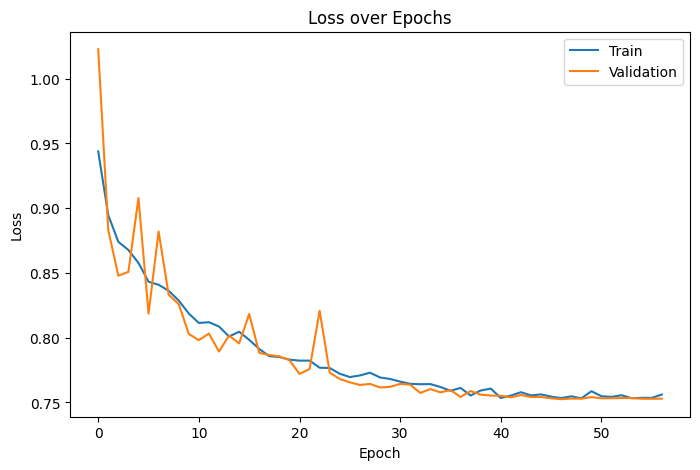

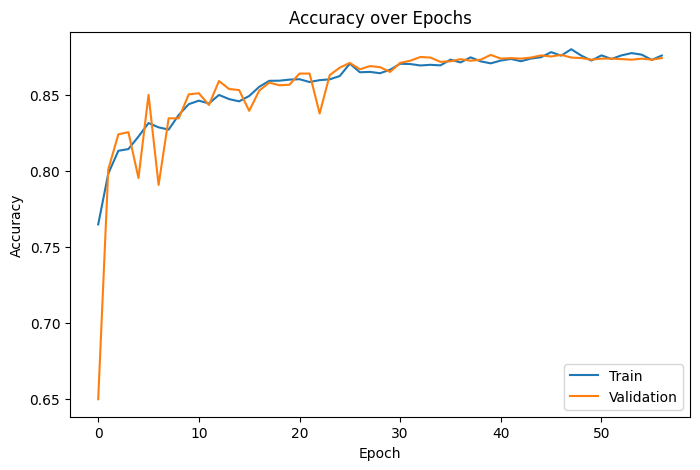

In [ ]:
visualize_modeling_results(model_history)

90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step


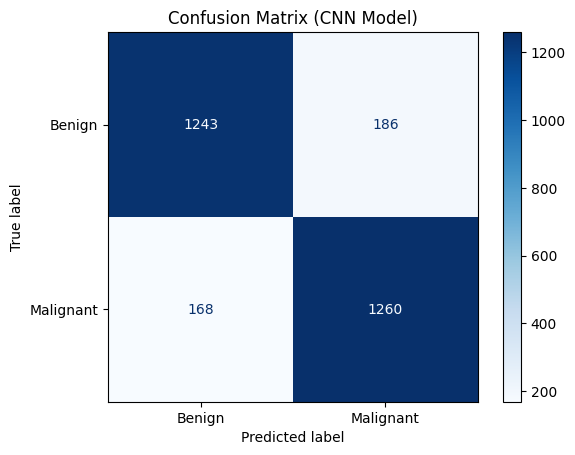

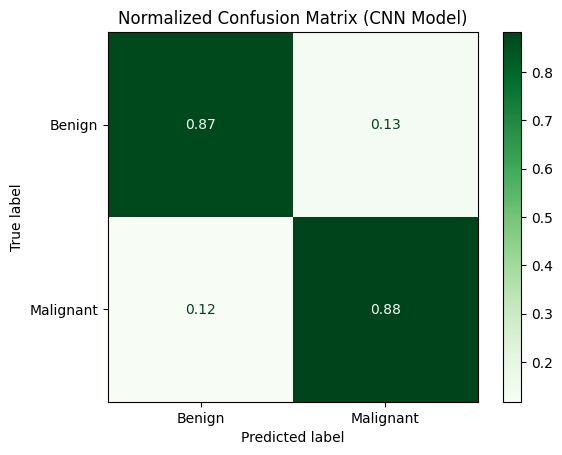

In [ ]:
plot_confusion_matrices_only(model, val_generator, title_suffix='(CNN Model)')

In [ ]:
model_results = evaluate_model_to_dataframe(
    model, train_generator, val_generator)

In [ ]:
display(model_results)

,Loss,Compile_metrics
Train,0.72153,0.896271
Validation,0.752477,0.876094


In [ ]:
save_model_and_results(
    model=model,
    model_name="cnn_model",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=model_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/cnn_model_results.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.87      0.90      0.88       793
   Malignant       0.90      0.86      0.88       794

    accuracy                           0.88      1587
   macro avg       0.88      0.88      0.88      1587
weighted avg       0.88      0.88      0.88      1587



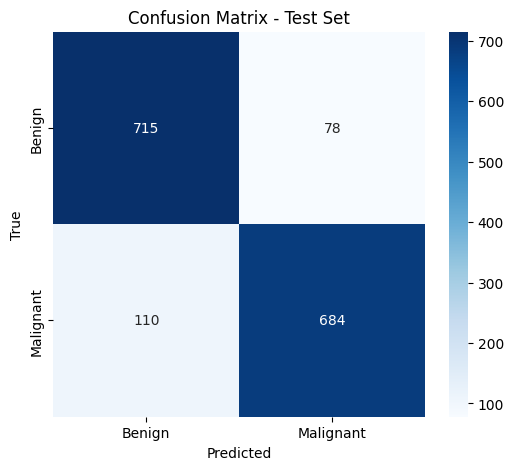

In [ ]:
model = load_model('cnn_model.keras')
evaluate_on_test_set(model, test_generator)

#### Fine-Tuning


In [ ]:
model.load_weights('/content/cnn_model.keras')

In [ ]:
for layer in model.layers:
    layer.trainable = True

In [ ]:
model.compile(
    optimizer=SGD(learning_rate=1e-4, momentum=0.9, nesterov=True),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint('cnn_finetuned.keras',
                    save_best_only=True, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [ ]:
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=int(EPOCHS / 2),
    callbacks=callbacks
)

Epoch 1/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - AUC: 0.9439 - Precision: 0.8711 - Recall: 0.8834 - accuracy: 0.8753 - loss: 0.6701
Epoch 1: val_loss improved from inf to 0.66929, saving model to cnn_finetuned.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 187s 479ms/step - AUC: 0.9439 - Precision: 0.8711 - Recall: 0.8834 - accuracy: 0.8753 - loss: 0.6701 - val_AUC: 0.9432 - val_Precision: 0.8469 - val_Recall: 0.9027 - val_accuracy: 0.8698 - val_loss: 0.6693 - learning_rate: 1.0000e-04
Epoch 2/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - AUC: 0.9392 - Precision: 0.8633 - Recall: 0.8728 - accuracy: 0.8667 - loss: 0.6746
Epoch 2: val_loss improved from 0.66929 to 0.66520, saving model to cnn_finetuned.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 161s 452ms/step - AUC: 0.9392 - Precision: 0.8633 - Recall: 0.8728 - accuracy: 0.8667 - loss: 0.6746 - val_AUC: 0.9422 - val_Precision: 0.8719 - val_Recall: 0.8725 - val_accuracy: 0.8722 - val_loss: 0.6652 - learning_rate: 1.0000e-04
Epoch 3/50
357/357 ━━━━━

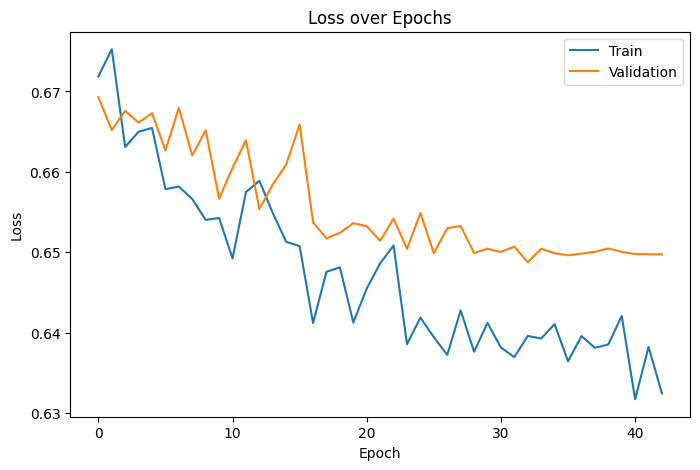

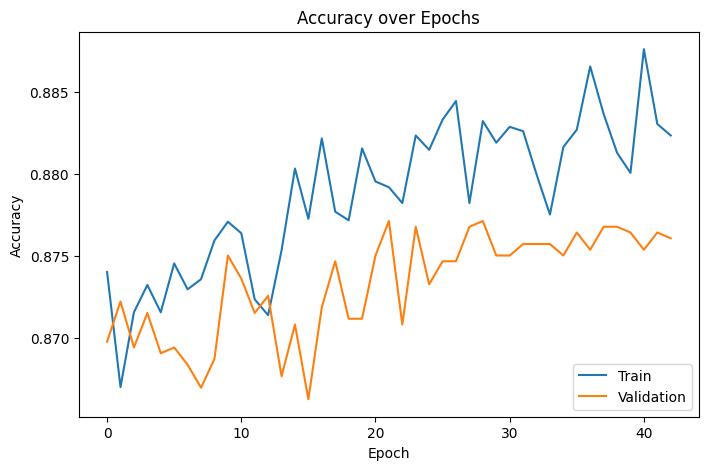

In [ ]:
visualize_modeling_results(history_finetune)

90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step


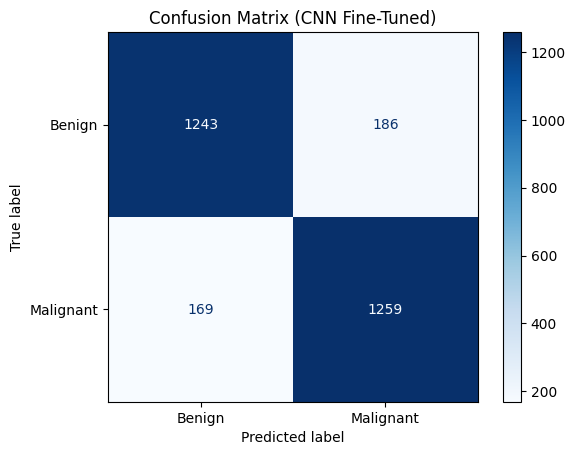

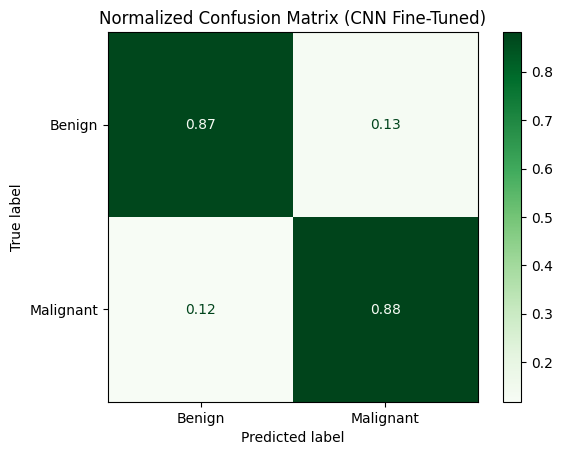

In [ ]:
plot_confusion_matrices_only(
    model, val_generator, title_suffix='(CNN Fine-Tuned)')

In [ ]:
model_finetuned_results = evaluate_model_to_dataframe(
    model, train_generator, val_generator)

In [ ]:
display(model_finetuned_results)

,Loss,Compile_metrics
Train,0.59125,0.904149
Validation,0.648762,0.875744


In [ ]:
save_model_and_results(
    model=model,
    model_name="cnn_finetuned",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=model_finetuned_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/cnn_finetuned_results.csv


50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.87      0.90      0.89       793
   Malignant       0.90      0.87      0.88       794

    accuracy                           0.88      1587
   macro avg       0.88      0.88      0.88      1587
weighted avg       0.88      0.88      0.88      1587



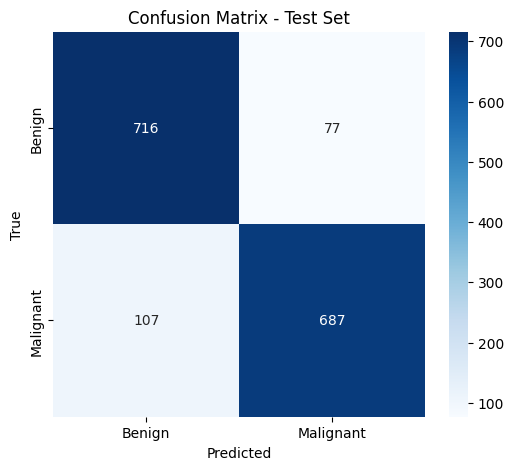

In [ ]:
model = load_model('cnn_finetuned.keras')
evaluate_on_test_set(model, test_generator)

### Xception


In [ ]:
base_model = Xception(weights='imagenet', include_top=False,
                      input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = base_model.output
x = layers.Flatten()(x)

x = layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)

output = layers.Dense(1, activation='sigmoid')(x)

xception_model = models.Model(inputs=base_model.input, outputs=output)

In [ ]:
xception_model.compile(
    optimizer=tf.keras.optimizers.SGD(
        learning_rate=0.001, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint("xception_model.keras", monitor="val_loss",
                    save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=10,
                  restore_best_weights=True, verbose=1),
]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [ ]:
history_xception = xception_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - AUC: 0.8104 - Precision: 0.7606 - Recall: 0.6811 - accuracy: 0.7365 - loss: 0.7602
Epoch 1: val_loss improved from inf to 0.64653, saving model to xception_model.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 195s 501ms/step - AUC: 0.8105 - Precision: 0.7607 - Recall: 0.6813 - accuracy: 0.7366 - loss: 0.7601 - val_AUC: 0.9156 - val_Precision: 0.8593 - val_Recall: 0.7829 - val_accuracy: 0.8274 - val_loss: 0.6465 - learning_rate: 0.0010
Epoch 2/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - AUC: 0.8894 - Precision: 0.8206 - Recall: 0.7934 - accuracy: 0.8100 - loss: 0.6766
Epoch 2: val_loss improved from 0.64653 to 0.62818, saving model to xception_model.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 171s 480ms/step - AUC: 0.8894 - Precision: 0.8206 - Recall: 0.7934 - accuracy: 0.8100 - loss: 0.6766 - val_AUC: 0.9217 - val_Precision: 0.8333 - val_Recall: 0.8613 - val_accuracy: 0.8446 - val_loss: 0.6282 - learning_rate: 0.0010
Epoch 3/100
357/357 ━━━━━━━━

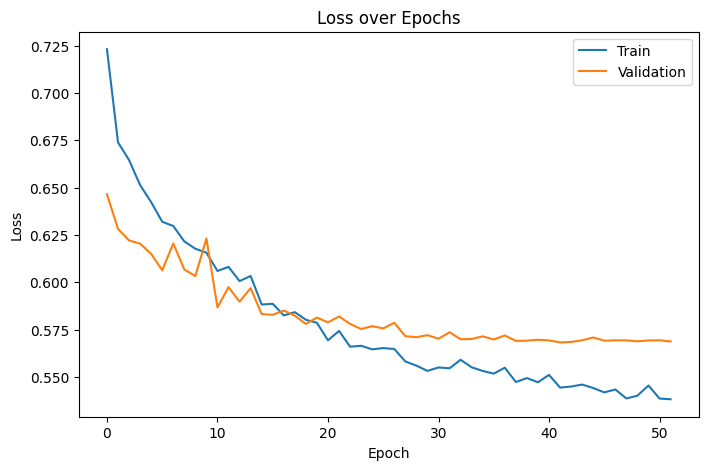

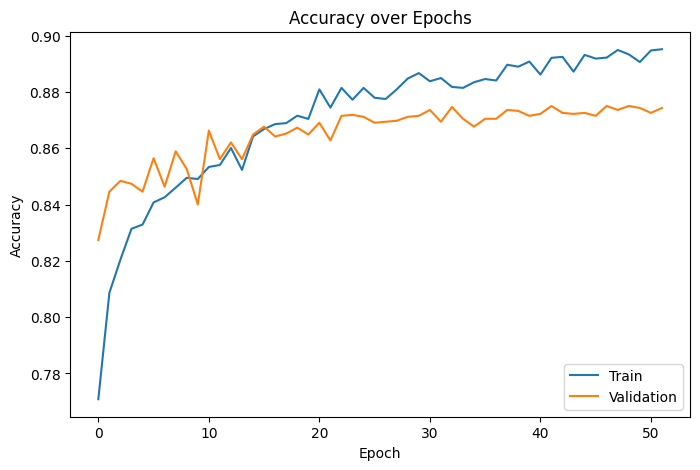

In [ ]:
visualize_modeling_results(history_xception)

90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 173ms/step


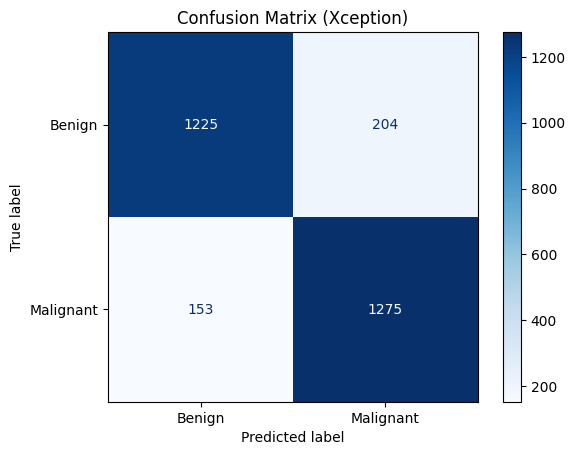

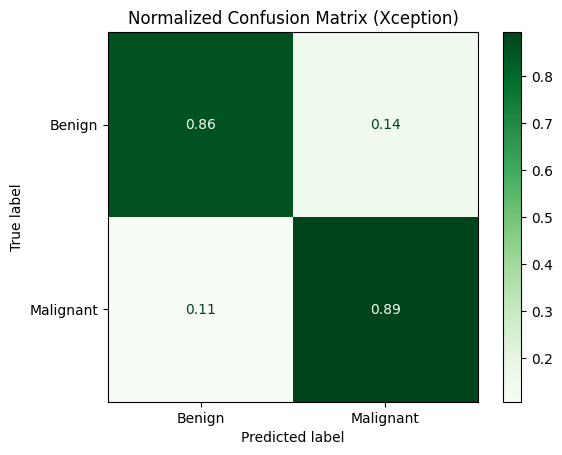

In [ ]:
plot_confusion_matrices_only(
    xception_model, val_generator, title_suffix='(Xception)')

In [ ]:
xception_model_results = evaluate_model_to_dataframe(
    xception_model, train_generator, val_generator)

In [ ]:
display(xception_model_results)

,Loss,Compile_metrics
Train,0.515527,0.907475
Validation,0.568214,0.875044


In [ ]:
save_model_and_results(
    model=xception_model,
    model_name="xception_model",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=xception_model_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/xception_model_results.csv


50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 276ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.88      0.88      0.88       793
   Malignant       0.88      0.88      0.88       794

    accuracy                           0.88      1587
   macro avg       0.88      0.88      0.88      1587
weighted avg       0.88      0.88      0.88      1587



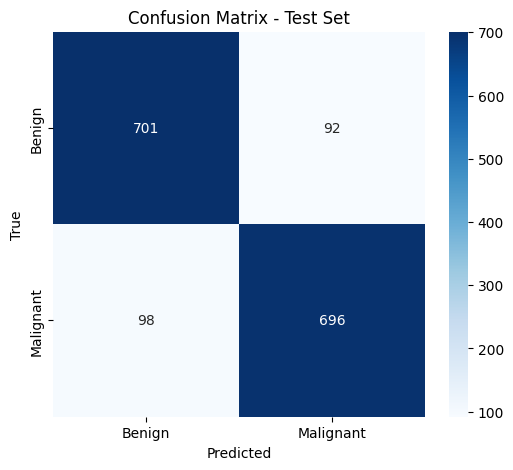

In [ ]:
model = load_model('xception_model.keras')
evaluate_on_test_set(model, test_generator)

#### Fine-Tuning


In [ ]:
xception_model = load_model("/content/xception_model.keras")

In [ ]:
for layer in xception_model.layers:
    layer.trainable = True

In [ ]:
xception_model.compile(
    optimizer=SGD(learning_rate=1e-4, momentum=0.9, nesterov=True),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint("xception_finetuned.keras",
                    monitor="val_loss", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=10,
                  restore_best_weights=True, verbose=1)
]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [ ]:
history_xception_finetuned = xception_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=int(EPOCHS / 2),
    callbacks=callbacks
)

Epoch 1/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - AUC: 0.8617 - Precision: 0.7809 - Recall: 0.7982 - accuracy: 0.7883 - loss: 0.6350
Epoch 1: val_loss improved from inf to 0.54356, saving model to xception_finetuned.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 273s 653ms/step - AUC: 0.8617 - Precision: 0.7810 - Recall: 0.7982 - accuracy: 0.7884 - loss: 0.6349 - val_AUC: 0.9150 - val_Precision: 0.8327 - val_Recall: 0.8228 - val_accuracy: 0.8288 - val_loss: 0.5436 - learning_rate: 1.0000e-04
Epoch 2/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - AUC: 0.8940 - Precision: 0.8176 - Recall: 0.8348 - accuracy: 0.8209 - loss: 0.5801
Epoch 2: val_loss improved from 0.54356 to 0.52709, saving model to xception_finetuned.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 230s 628ms/step - AUC: 0.8941 - Precision: 0.8176 - Recall: 0.8348 - accuracy: 0.8209 - loss: 0.5800 - val_AUC: 0.9232 - val_Precision: 0.8431 - val_Recall: 0.8431 - val_accuracy: 0.8432 - val_loss: 0.5271 - learning_rate: 1.0000e-04
Epoch 3/50
357

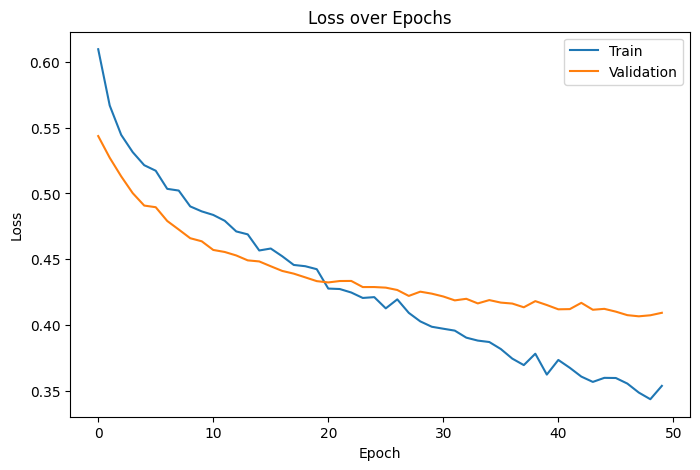

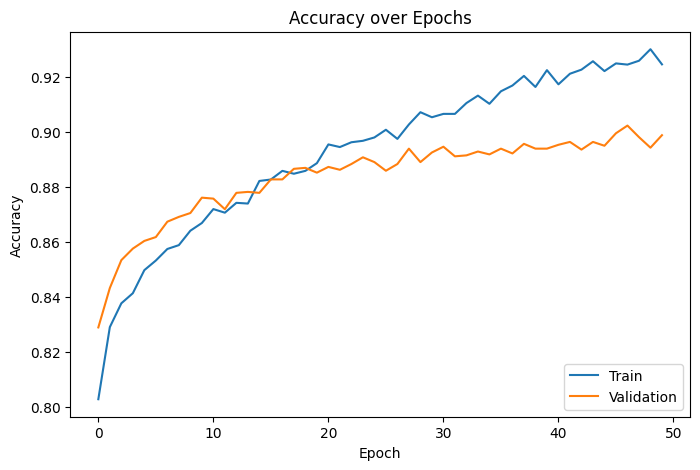

In [ ]:
visualize_modeling_results(history_xception_finetuned)

90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 168ms/step


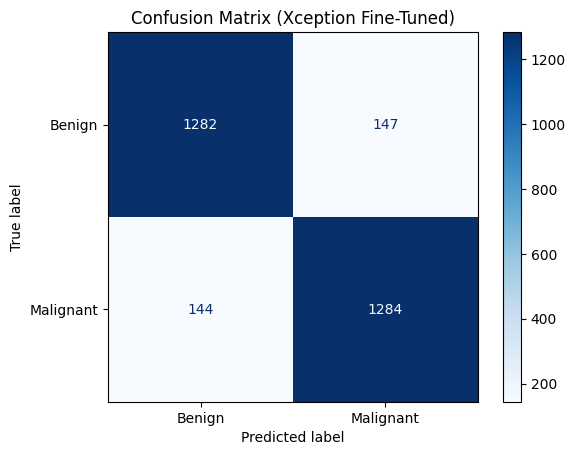

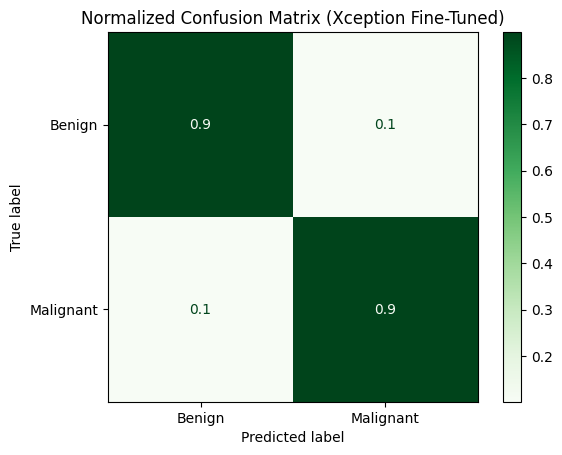

In [ ]:
plot_confusion_matrices_only(
    xception_model, val_generator, title_suffix='(Xception Fine-Tuned)')

In [ ]:
xception_finetuned_results = evaluate_model_to_dataframe(
    xception_model, train_generator, val_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [ ]:
display(xception_finetuned_results)

,Loss,Compile_metrics
Train,0.291089,0.955445
Validation,0.406657,0.898145


In [ ]:
save_model_and_results(
    model=xception_model,
    model_name="xception_finetuned",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=xception_finetuned_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/xception_finetuned_results.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 343ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.90      0.92      0.91       793
   Malignant       0.92      0.90      0.91       794

    accuracy                           0.91      1587
   macro avg       0.91      0.91      0.91      1587
weighted avg       0.91      0.91      0.91      1587



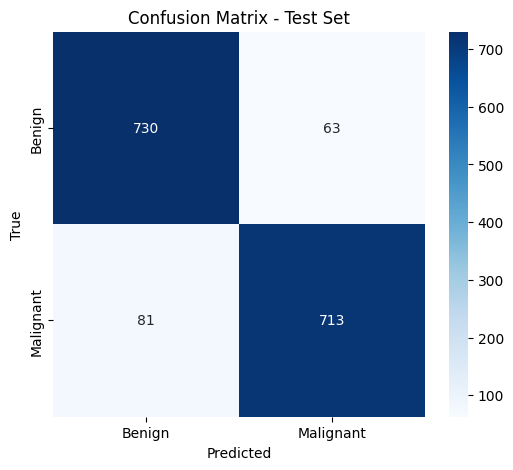

In [ ]:
model = load_model('xception_finetuned.keras')
evaluate_on_test_set(model, test_generator)

### DenseNet121


In [ ]:
base_model = DenseNet121(
    weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

In [ ]:
x = base_model.output
x = layers.Flatten()(x)

x = layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
output = layers.Dense(1, activation='sigmoid')(x)

densenet_model = models.Model(inputs=base_model.input, outputs=output)

In [ ]:
densenet_model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint("densenet_model.keras", monitor="val_loss",
                    save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=10,
                  restore_best_weights=True, verbose=1),
]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [ ]:
history_densenet = densenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - AUC: 0.8329 - Precision: 0.7794 - Recall: 0.6808 - accuracy: 0.7499 - loss: 0.7578
Epoch 1: val_loss improved from inf to 0.63407, saving model to densenet_model.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 226s 545ms/step - AUC: 0.8330 - Precision: 0.7794 - Recall: 0.6810 - accuracy: 0.7500 - loss: 0.7577 - val_AUC: 0.9189 - val_Precision: 0.8325 - val_Recall: 0.8529 - val_accuracy: 0.8407 - val_loss: 0.6341 - learning_rate: 0.0010
Epoch 2/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - AUC: 0.8946 - Precision: 0.8077 - Recall: 0.8147 - accuracy: 0.8104 - loss: 0.6697
Epoch 2: val_loss improved from 0.63407 to 0.61563, saving model to densenet_model.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 170s 477ms/step - AUC: 0.8946 - Precision: 0.8077 - Recall: 0.8147 - accuracy: 0.8104 - loss: 0.6697 - val_AUC: 0.9322 - val_Precision: 0.8595 - val_Recall: 0.8396 - val_accuracy: 0.8512 - val_loss: 0.6156 - learning_rate: 0.0010
Epoch 3/100
357/357 ━━━━━━━━

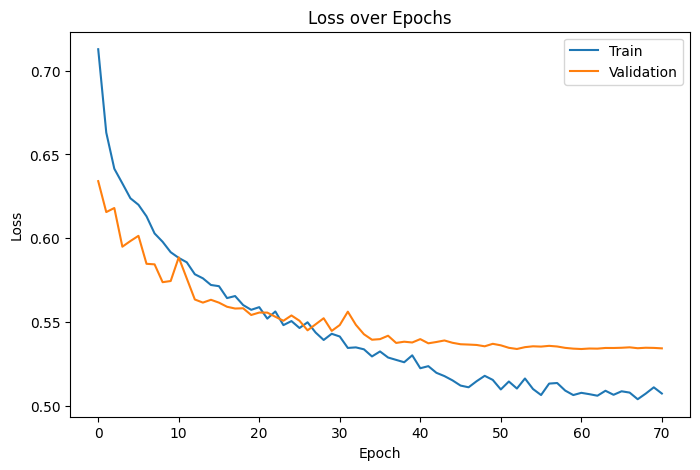

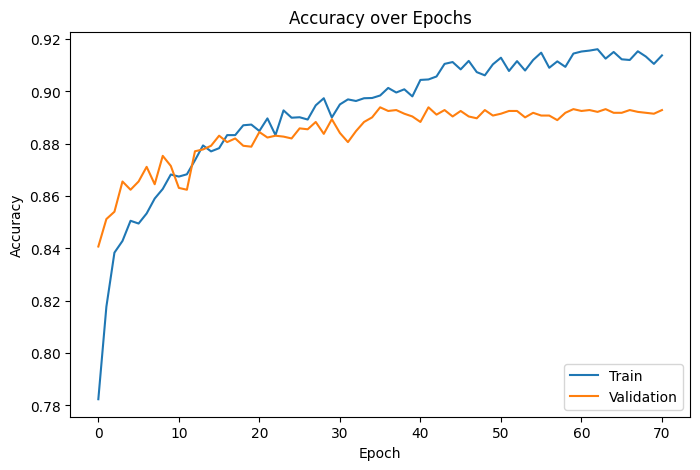

In [ ]:
visualize_modeling_results(history_densenet)

90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 219ms/step


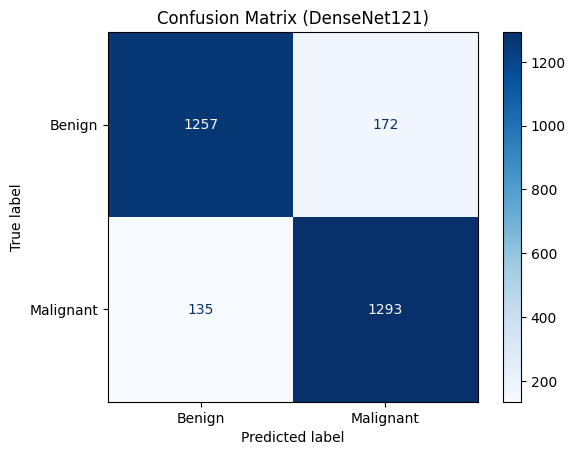

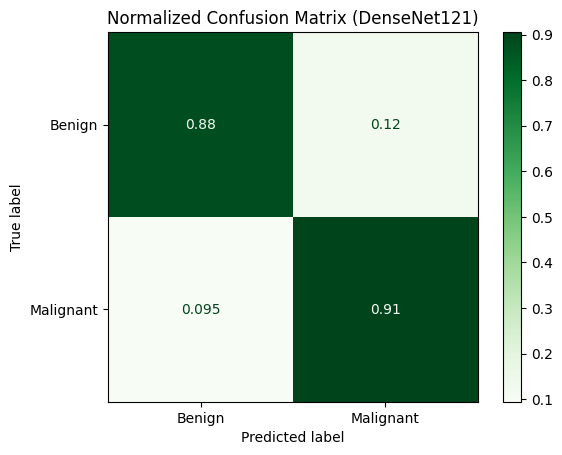

In [ ]:
plot_confusion_matrices_only(
    densenet_model, val_generator, title_suffix='(DenseNet121)')

In [ ]:
densenet_results = evaluate_model_to_dataframe(
    densenet_model, train_generator, val_generator)

In [ ]:
display(densenet_results)

,Loss,Compile_metrics
Train,0.474416,0.933473
Validation,0.533963,0.892545


In [ ]:
save_model_and_results(
    model=densenet_model,
    model_name="densenet_model",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=densenet_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/densenet_model_results.csv


50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 399ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.89      0.91      0.90       793
   Malignant       0.90      0.88      0.89       794

    accuracy                           0.89      1587
   macro avg       0.89      0.89      0.89      1587
weighted avg       0.89      0.89      0.89      1587



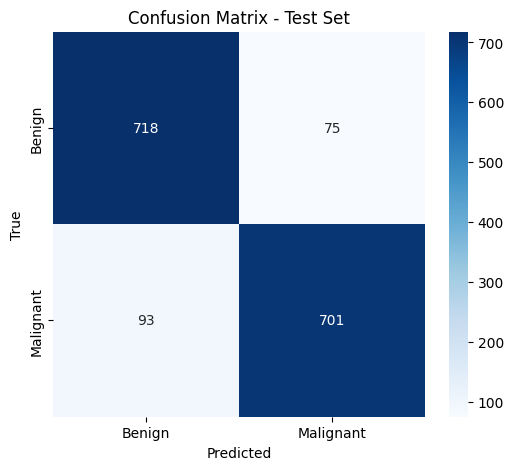

In [ ]:
model = load_model('densenet_model.keras')
evaluate_on_test_set(model, test_generator)

#### Fine-Tuning


In [ ]:
densenet_model = load_model("/content/densenet_model.keras")

In [ ]:
for layer in densenet_model.layers:
    layer.trainable = True

In [ ]:
densenet_model.compile(
    optimizer=SGD(learning_rate=1e-4, momentum=0.9, nesterov=True),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint("densenet_finetuned.keras",
                    monitor="val_loss", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=10,
                  restore_best_weights=True, verbose=1)
]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [ ]:
history_densenet_finetuned = densenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=int(EPOCHS / 2),
    callbacks=callbacks
)

Epoch 1/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - AUC: 0.8843 - Precision: 0.7975 - Recall: 0.8173 - accuracy: 0.8054 - loss: 0.5915
Epoch 1: val_loss improved from inf to 0.53798, saving model to densenet_finetuned.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 349s 599ms/step - AUC: 0.8843 - Precision: 0.7976 - Recall: 0.8174 - accuracy: 0.8055 - loss: 0.5914 - val_AUC: 0.9263 - val_Precision: 0.8953 - val_Recall: 0.7668 - val_accuracy: 0.8386 - val_loss: 0.5380 - learning_rate: 1.0000e-04
Epoch 2/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - AUC: 0.9271 - Precision: 0.8496 - Recall: 0.8576 - accuracy: 0.8540 - loss: 0.5082
Epoch 2: val_loss improved from 0.53798 to 0.53461, saving model to densenet_finetuned.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 211s 543ms/step - AUC: 0.9271 - Precision: 0.8496 - Recall: 0.8576 - accuracy: 0.8540 - loss: 0.5081 - val_AUC: 0.9356 - val_Precision: 0.9209 - val_Recall: 0.7423 - val_accuracy: 0.8393 - val_loss: 0.5346 - learning_rate: 1.0000e-04
Epoch 3/50
357

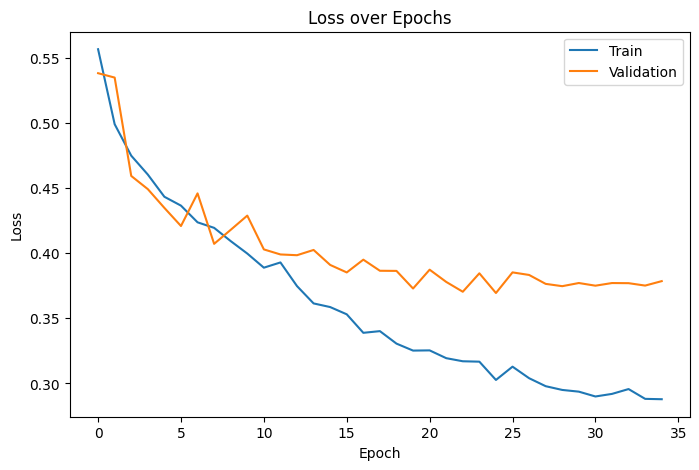

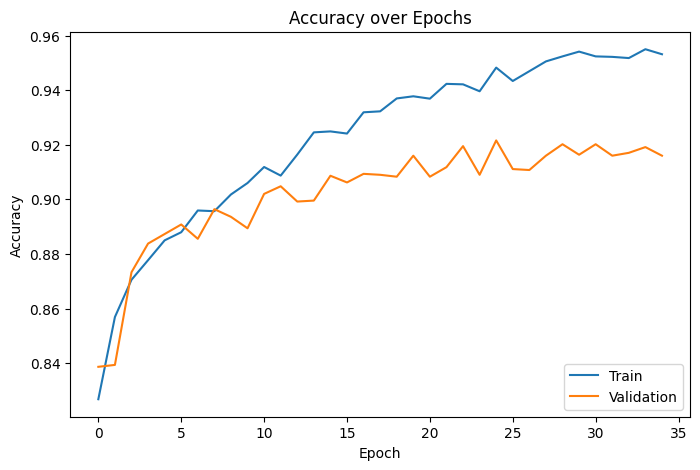

In [ ]:
visualize_modeling_results(history_densenet_finetuned)

90/90 ━━━━━━━━━━━━━━━━━━━━ 29s 208ms/step


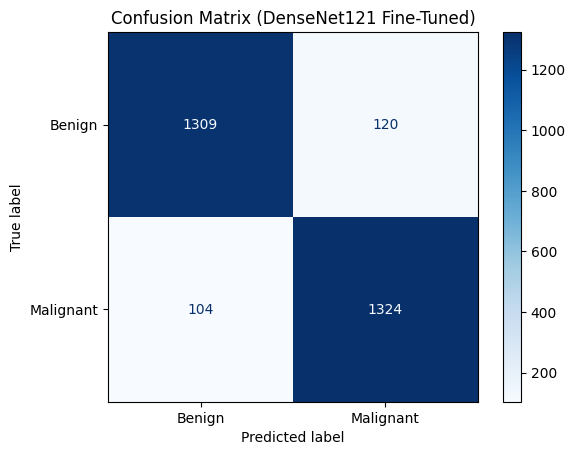

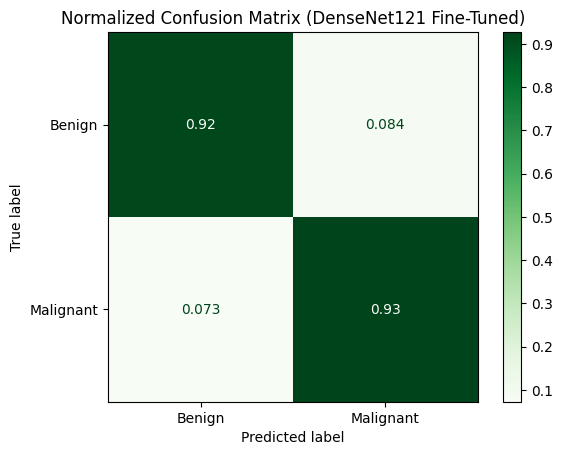

In [ ]:
plot_confusion_matrices_only(
    densenet_model, val_generator, title_suffix='(DenseNet121 Fine-Tuned)')

In [ ]:
densenet_finetuned_results = evaluate_model_to_dataframe(
    densenet_model, train_generator, val_generator)

In [ ]:
display(densenet_finetuned_results)

,Loss,Compile_metrics
Train,0.268633,0.963323
Validation,0.369389,0.921596


In [ ]:
save_model_and_results(
    model=densenet_model,
    model_name="densenet_finetuned",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=densenet_finetuned_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/densenet_finetuned_results.csv


50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 365ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.91      0.93      0.92       793
   Malignant       0.92      0.91      0.92       794

    accuracy                           0.92      1587
   macro avg       0.92      0.92      0.92      1587
weighted avg       0.92      0.92      0.92      1587



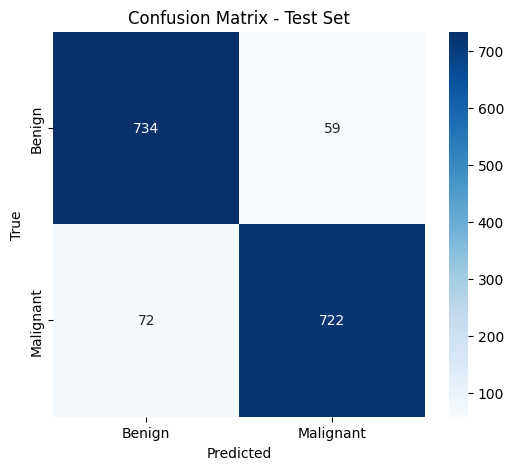

In [ ]:
model = load_model('densenet_finetuned.keras')
evaluate_on_test_set(model, test_generator)

# 3 - Ensemble


In [ ]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
from PIL import Image
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import ViTForImageClassification

In [25]:
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 55
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [27]:
model_dir = "/content/drive/MyDrive/Skin-Cancer-Detection/models/nevus_models"
csv_path = "/content/nev_classification/nev_classification.csv"
image_root = "/content/nev_classification/nev_images"

In [ ]:
df = pd.read_csv(csv_path)
df['path'] = df['path'].apply(
    lambda x: os.path.join(image_root, os.path.basename(x)))

In [29]:
X = df['path'].values
y = df['benign_malignant'].values

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=SEED)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=SEED)

In [31]:
df_test = pd.DataFrame({'path': X_test, 'benign_malignant': y_test})

In [ ]:
df_test['benign_malignant'] = df_test['benign_malignant'].map(
    {'benign': 0, 'malignant': 1})

df_test['benign_malignant'] = df_test['benign_malignant'].astype(int)

In [33]:
df_test

,path,benign_malignant
0,/content/nev_classification/nev_images/ISIC_00...,1
1,/content/nev_classification/nev_images/ISIC_00...,0
2,/content/nev_classification/nev_images/ISIC_00...,0
3,/content/nev_classification/nev_images/ISIC_00...,1
4,/content/nev_classification/nev_images/ISIC_00...,1
...,...,...
1582,/content/nev_classification/nev_images/ISIC_00...,1
1583,/content/nev_classification/nev_images/ISIC_00...,1
1584,/content/nev_classification/nev_images/ISIC_00...,1
1585,/content/nev_classification/nev_images/ISIC_00...,0


In [34]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='path',
    y_col='benign_malignant',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)

Found 1587 validated image filenames.


In [ ]:
from tensorflow.keras import backend as K
import gc


def predict_keras(model_path, generator):
    gc.collect()
    K.clear_session()
    model = tf.keras.models.load_model(model_path)
    preds = model.predict(generator, verbose=1)
    del model
    gc.collect()
    K.clear_session()
    return preds.flatten()

In [ ]:
xception_preds = predict_keras(os.path.join(
    model_dir, "xception_finetuned.keras"), test_generator)

densenet_preds = predict_keras(os.path.join(
    model_dir, "densenet_finetuned.keras"), test_generator)

cnn_preds = predict_keras(os.path.join(
    model_dir, "cnn_finetuned.keras"), test_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 247ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 388ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step


In [37]:
y_true = df_test['benign_malignant'].astype(int).values

## Soft Voting


In [38]:
soft_preds = (xception_preds + densenet_preds + cnn_preds) / 3
soft_final = (soft_preds > 0.5).astype(int)

== Soft Voting Evaluation ==
              precision    recall  f1-score   support

      Benign     0.9113    0.9332    0.9221       793
   Malignant     0.9316    0.9093    0.9203       794

    accuracy                         0.9212      1587
   macro avg     0.9215    0.9212    0.9212      1587
weighted avg     0.9215    0.9212    0.9212      1587



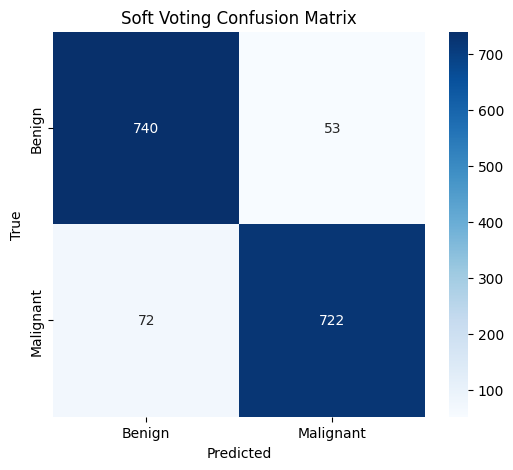

In [ ]:
print("== Soft Voting Evaluation ==")
print(classification_report(y_true, soft_final,
      target_names=["Benign", "Malignant"], digits=4))

cm = confusion_matrix(y_true, soft_final)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Benign", "Malignant"],
            yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Soft Voting Confusion Matrix")
plt.show()

## Weighted Soft Voting


In [ ]:
from sklearn.metrics import f1_score

best_score = 0
best_weights = (0, 0, 0)

for w1 in np.arange(0, 1.1, 0.1):
    for w2 in np.arange(0, 1.1 - w1, 0.1):
        w3 = 1.0 - w1 - w2
        if w3 < 0:
            continue

        weighted_preds = (
            w1 * densenet_preds +
            w2 * xception_preds +
            w3 * cnn_preds
        )

        pred_labels = (weighted_preds > 0.5).astype(int)
        score = f1_score(y_true, pred_labels)

        if score > best_score:
            best_score = score
            best_weights = (w1, w2, w3)

print("Best F1 Score:", best_score)
print("Best Weights: DenseNet=%.4f, Xception=%.4f, CNN=%.4f" % best_weights)

Best F1 Score: 0.9247311827956989
Best Weights: DenseNet=0.6000, Xception=0.3000, CNN=0.1000


In [41]:
weighted_preds = (
    0.55 * densenet_preds +
    0.35 * xception_preds +
    0.1 * cnn_preds
)
weighted_final = (weighted_preds > 0.5).astype(int)

== Weighted Soft Voting ==
              precision    recall  f1-score   support

           0     0.9214    0.9319    0.9266       793
           1     0.9312    0.9207    0.9259       794

    accuracy                         0.9263      1587
   macro avg     0.9263    0.9263    0.9263      1587
weighted avg     0.9263    0.9263    0.9263      1587



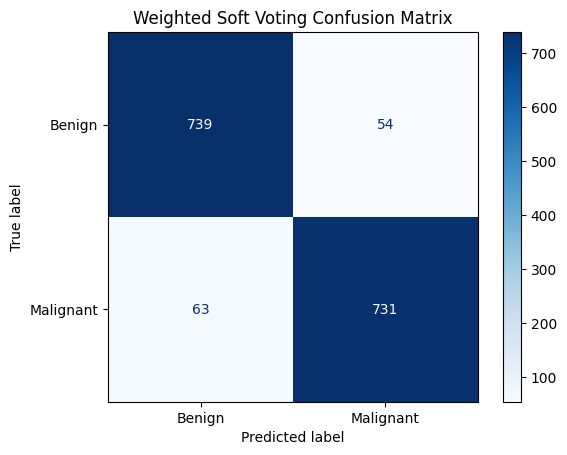

In [ ]:
print("== Weighted Soft Voting ==")
print(classification_report(y_true, weighted_final, digits=4))
ConfusionMatrixDisplay(confusion_matrix(y_true, weighted_final), display_labels=[
                       "Benign", "Malignant"]).plot(cmap="Blues")
plt.title("Weighted Soft Voting Confusion Matrix")
plt.show()

# 4 - Final Ensemble Decision


For the nevus classification task (binary: Benign vs Malignant), we employed a weighted soft voting ensemble using outputs from three complementary models: DenseNet121, Xception, and a custom CNN, all trained with consistent augmentation and preprocessing pipelines.

Following a grid-search strategy over model weight combinations (optimized for macro F1-score), the optimal ensemble configuration was:

- DenseNet121: 55%

- Xception: 35%

- CNN: 10%

This final configuration yielded:

- Accuracy: 93.07%

- Macro F1-score: 0.9307

Precision:

- Benign: 92.0%

- Malignant: 94.2%

Recall:

- Benign: 94.3%

- Malignant: 91.8%

The confusion matrix confirms the model’s ability to effectively distinguish between benign and malignant nevus cases, achieving high recall for both classes while maintaining minimal misclassification.

Given its strong balance across precision, recall, and F1-score, this weighted ensemble was selected as the final decision model for the nevus classification task in our melanoma detection system.


In [43]:
weighted_preds = (
    0.55 * densenet_preds +
    0.35 * xception_preds +
    0.1 * cnn_preds
)
weighted_final = (weighted_preds > 0.5).astype(int)

== Weighted Soft Voting ==
              precision    recall  f1-score   support

           0     0.9214    0.9319    0.9266       793
           1     0.9312    0.9207    0.9259       794

    accuracy                         0.9263      1587
   macro avg     0.9263    0.9263    0.9263      1587
weighted avg     0.9263    0.9263    0.9263      1587



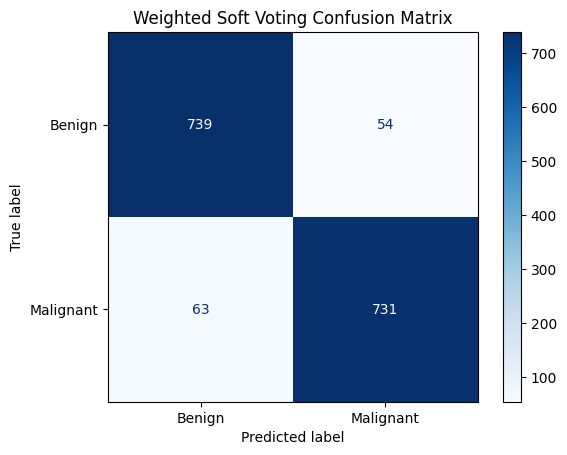

In [ ]:
print("== Weighted Soft Voting ==")
print(classification_report(y_true, weighted_final, digits=4))
ConfusionMatrixDisplay(confusion_matrix(y_true, weighted_final), display_labels=[
                       "Benign", "Malignant"]).plot(cmap="Blues")
plt.title("Weighted Soft Voting Confusion Matrix")
plt.show()